In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm


In [111]:
# Load dataset
df = pd.read_csv(r"C:\\Users\\Lenovo\\OneDrive\\Desktop\\Regression Project\\dataset.csv")

# Initial cleanup
df['YEAR'] = df['YEAR'].astype(str).str.extract(r'(\d{4})')
df['GENRE'] = df['GENRE'].str.strip()
df['VOTES'] = pd.to_numeric(df['VOTES'].str.replace(',', '', regex=False), errors='coerce')
df['Gross'] = pd.to_numeric(df['Gross'].str.replace(r'[^\d.]', '', regex=True), errors='coerce')
df['YEAR'] = pd.to_numeric(df['YEAR'], errors='coerce')
# Drop rows with missing target
df = df[df['RATING'].notna()]


In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8179 entries, 0 to 9979
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MOVIES    8179 non-null   object 
 1   YEAR      8179 non-null   float64
 2   GENRE     8168 non-null   object 
 3   RATING    8179 non-null   float64
 4   ONE-LINE  8179 non-null   object 
 5   STARS     8179 non-null   object 
 6   VOTES     8179 non-null   float64
 7   RunTime   6786 non-null   float64
 8   Gross     460 non-null    float64
dtypes: float64(5), object(4)
memory usage: 639.0+ KB


In [115]:
features = ['GENRE', 'RunTime', 'YEAR', 'VOTES']
target = 'RATING'

X = df[features].copy()
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


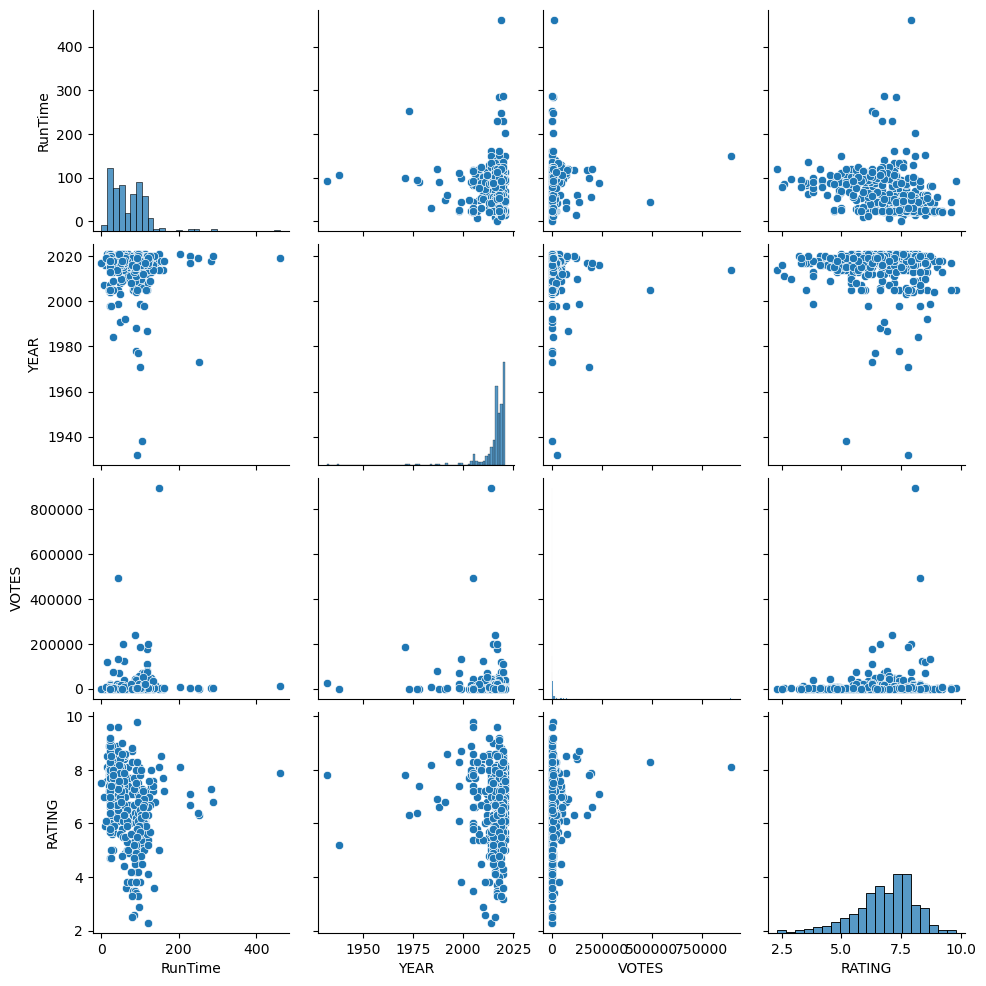

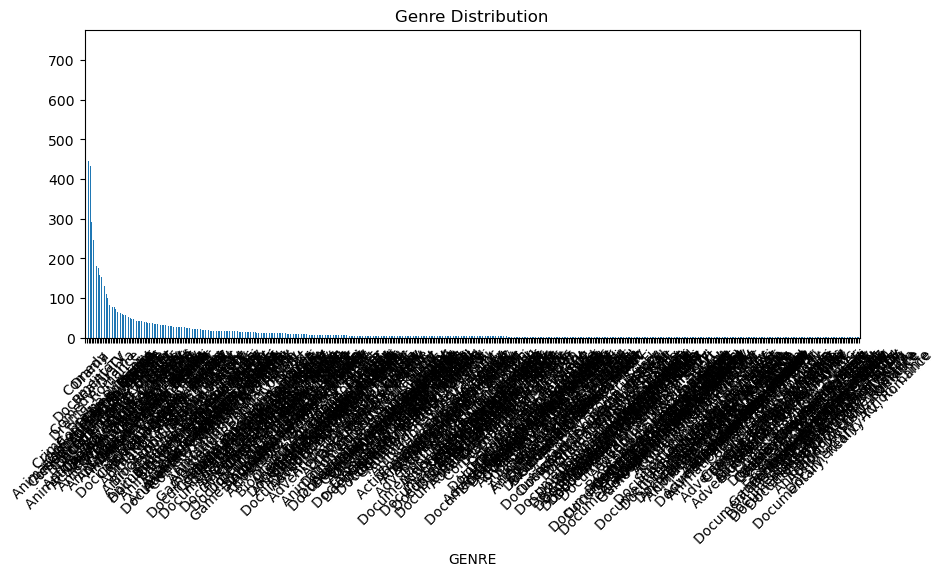

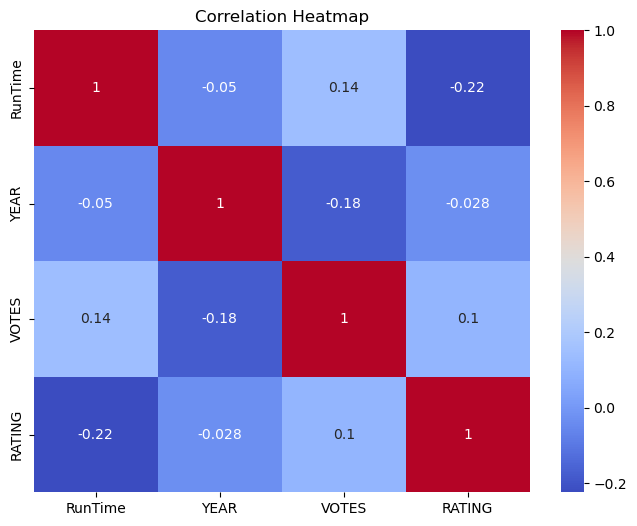

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize numeric distributions
sns.pairplot(df[['RunTime', 'YEAR', 'VOTES', 'RATING']].sample(500))
plt.show()

# Genre distribution
plt.figure(figsize=(10,4))
df['GENRE'].value_counts().plot(kind='bar')
plt.title('Genre Distribution')
plt.xticks(rotation=45)
plt.show()

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df[['RunTime', 'YEAR', 'VOTES', 'RATING']].corr(), annot=True, cmap="coolwarm")
plt.title('Correlation Heatmap')
plt.show()


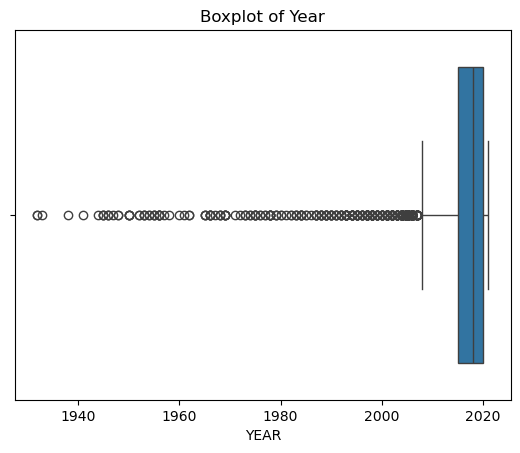

In [118]:
sns.boxplot(x=df['YEAR'])
plt.title('Boxplot of Year')
plt.show()

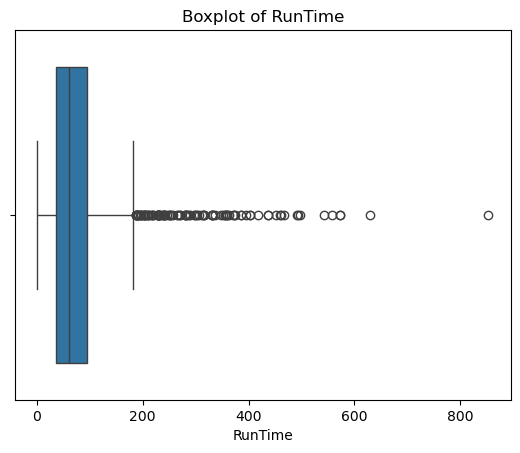

In [119]:
sns.boxplot(x=df['RunTime'])
plt.title('Boxplot of RunTime')
plt.show()

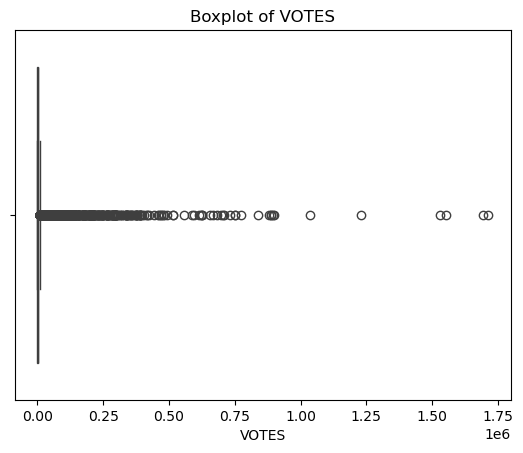

In [120]:
sns.boxplot(x=df['VOTES'])
plt.title('Boxplot of VOTES')
plt.show()

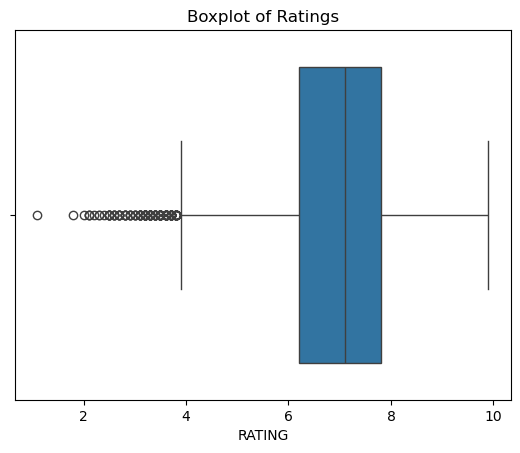

In [121]:
sns.boxplot(x=df['RATING'])
plt.title('Boxplot of Ratings')
plt.show()

In [122]:
# Combine X_train and y_train for joint filtering
train_df = X_train.copy()
train_df['RATING'] = y_train

# Fill missing values in predictors using training medians
for col in ['RunTime', 'YEAR', 'VOTES']:
    median = train_df[col].median()
    train_df[col] = train_df[col].fillna(median)
    X_test[col] = X_test[col].fillna(median)

# Remove outliers based only on training data



In [123]:
for col in ['RunTime', 'VOTES', 'YEAR', 'RATING']:
    Q1 = train_df[col].quantile(0.25)
    Q3 = train_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    train_df = train_df[(train_df[col] >= lower) & (train_df[col] <= upper)]

# Separate back into X_train and y_train
X_train = train_df.drop(columns=['RATING'])
y_train = train_df['RATING']

In [124]:
X_train.info()
X_test.info()


<class 'pandas.core.frame.DataFrame'>
Index: 4873 entries, 8409 to 8456
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   GENRE    4872 non-null   object 
 1   RunTime  4873 non-null   float64
 2   YEAR     4873 non-null   float64
 3   VOTES    4873 non-null   float64
dtypes: float64(3), object(1)
memory usage: 190.4+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 1636 entries, 9668 to 3129
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   GENRE    1629 non-null   object 
 1   RunTime  1636 non-null   float64
 2   YEAR     1636 non-null   float64
 3   VOTES    1636 non-null   float64
dtypes: float64(3), object(1)
memory usage: 63.9+ KB


In [125]:
X_train.loc[:, 'GENRE'] = X_train['GENRE'].fillna('Unknown').apply(lambda x: [g.strip() for g in x.split(',')])
X_test.loc[:, 'GENRE'] = X_test['GENRE'].fillna('Unknown').apply(lambda x: [g.strip() for g in x.split(',')])

mlb = MultiLabelBinarizer()
genre_train = pd.DataFrame(mlb.fit_transform(X_train['GENRE']), columns=mlb.classes_, index=X_train.index)
genre_test = pd.DataFrame(mlb.transform(X_test['GENRE']), columns=mlb.classes_, index=X_test.index)

X_train = pd.concat([X_train.drop(columns=['GENRE']), genre_train], axis=1)
X_test = pd.concat([X_test.drop(columns=['GENRE']), genre_test], axis=1)


C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:900: UserWarning: unknown class(es) ['Film-Noir'] will be ignored
  warnings.warn(


In [126]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Reduced from {X_train.shape[1]} to {X_train_pca.shape[1]} components.")


Reduced from 30 to 27 components.


In [127]:
model = LinearRegression()
model.fit(X_train_pca, y_train)

y_pred = model.predict(X_test_pca)


In [128]:
print("R² Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))


R² Score: -1.622958822515669
MSE: 3.9534134410708606


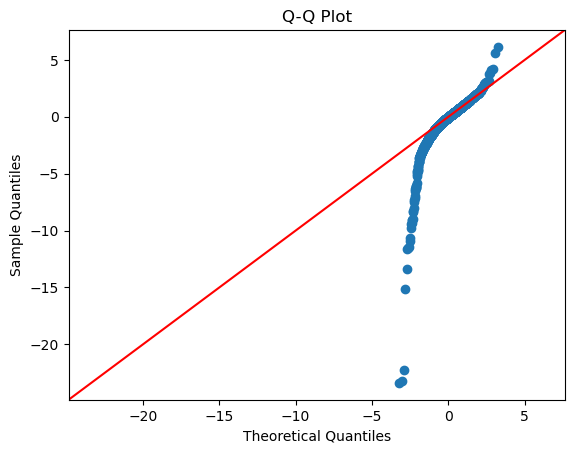

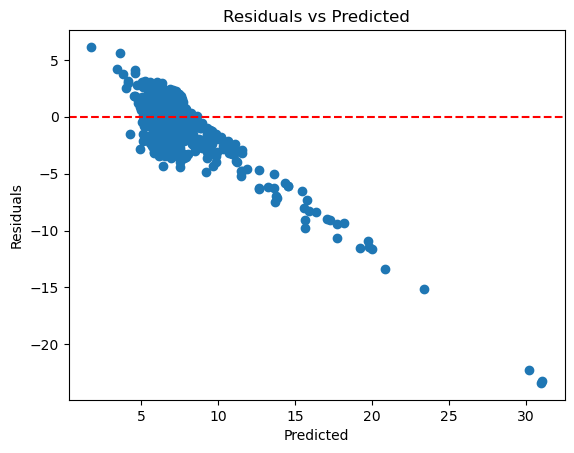

In [129]:
residuals = y_test - y_pred

# Q-Q plot
sm.qqplot(residuals, line='45')
plt.title("Q-Q Plot")
plt.show()

# Residuals vs predicted
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()


In [130]:
import joblib
joblib.dump(model, 'regression_model.pkl')


['regression_model.pkl']

In [131]:
import os
print(os.getcwd())


C:\Users\Lenovo


In [101]:
import os
print(os.getcwd())


C:\Users\Lenovo
